In [1]:
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv
from skimage import io
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import os
import cv2
from PIL import Image
import imageio
from tensorflow.python.ops import image_ops
import pandas as pd
import time
from tqdm import tqdm

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

#Check for CUDA on Windows
print("CUDA is available:", torch.cuda.is_available())

#Check on GPU for Mac
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

PyTorch version: 2.0.1
Torchvision version: 0.15.2
CUDA is available: False
True
True


In [5]:
#import du dataframe train
train_df = pd.read_csv('Dataframe/train_df.csv')
print('train_df shape =', train_df.shape)

train_df shape = (13673, 2)


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [4]:
#Choix du device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# chargement du modèle
sam_checkpoint = 'Model/sam_vit_h/sam_vit_h_4b8939.pth'
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [22]:
# Définition d'une liste contenant les chemins d'accès aux différentes images
MASK_DF = train_df.loc[train_df['target'] == 'BAS'][100:200]
IMAGE_PATH = np.array(MASK_DF['Path'])

# Définition des dimensions et positions des boxes et points appliqués sur chaque images pour limiter la segmentation a une partie restreinte de l'image
input_box = np.array([90, 90, 270, 270])
input_point = np.array([[180, 180]])
input_label = np.array([0])

# Création et enregistrement des masques pour chaque image
# for i in range(len(df.filepath)):
for i in tqdm(range(len(MASK_DF))):
  # lecture de l'image
  image_bgr = cv2.imread(IMAGE_PATH[i])
  # transformation en RGB
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

  start_time = time.time()
  predictor.set_image(image_rgb)
  end_time = time.time()
  set_image_time = end_time - start_time
  print("Temps pris par predictor.set_image() :", set_image_time, "secondes")

  start_time = time.time()
  masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
    )
  end_time = time.time()
  set_image_time = end_time - start_time
  print("Temps pris par predictor.predict() :", set_image_time, "secondes")

  # Chemin du dossier où vous souhaitez enregistrer l'image
  output_folder = 'Images/mask/' + IMAGE_PATH[i].split('/')[2]

  # Nom du fichier de sortie
  output_filename = str(MASK_DF['Path'].iloc[i]).split('/')[3].split('.')[0]+'_mask.png'

  # Chemin complet du fichier de sortie
  output_path = output_folder+'/'+output_filename

  mask_image = np.uint8(masks[0] * 255)

  # Save the mask image
  cv2.imwrite(output_path, mask_image)
  
  # Enregistrez l'image dans le fichier PNG
  print('L\'image n°', i, 'a été enregistrée sous :', output_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Temps pris par predictor.set_image() : 28.72443413734436 secondes


  1%|          | 1/100 [00:34<56:45, 34.40s/it]

Temps pris par predictor.predict() : 5.5331621170043945 secondes
L'image n° 0 a été enregistrée sous : Images/mask/basophil/BA_731815_mask.png
Temps pris par predictor.set_image() : 20.158591985702515 secondes


  2%|▏         | 2/100 [01:00<47:57, 29.36s/it]

Temps pris par predictor.predict() : 5.627165794372559 secondes
L'image n° 1 a été enregistrée sous : Images/mask/basophil/BA_163898_mask.png
Temps pris par predictor.set_image() : 22.581243991851807 secondes


  3%|▎         | 3/100 [01:28<46:39, 28.86s/it]

Temps pris par predictor.predict() : 5.643306255340576 secondes
L'image n° 2 a été enregistrée sous : Images/mask/basophil/BA_949913_mask.png
Temps pris par predictor.set_image() : 20.789252996444702 secondes


  4%|▍         | 4/100 [01:55<45:07, 28.20s/it]

Temps pris par predictor.predict() : 6.359514951705933 secondes
L'image n° 3 a été enregistrée sous : Images/mask/basophil/BA_173620_mask.png
Temps pris par predictor.set_image() : 22.863614797592163 secondes


  5%|▌         | 5/100 [02:24<44:46, 28.28s/it]

Temps pris par predictor.predict() : 5.48185396194458 secondes
L'image n° 4 a été enregistrée sous : Images/mask/basophil/BA_756115_mask.png
Temps pris par predictor.set_image() : 26.290662050247192 secondes


  6%|▌         | 6/100 [02:56<46:16, 29.53s/it]

Temps pris par predictor.predict() : 5.631904125213623 secondes
L'image n° 5 a été enregistrée sous : Images/mask/basophil/BA_578023_mask.png
Temps pris par predictor.set_image() : 22.104115962982178 secondes


  7%|▋         | 7/100 [03:23<44:47, 28.90s/it]

Temps pris par predictor.predict() : 5.395246982574463 secondes
L'image n° 6 a été enregistrée sous : Images/mask/basophil/BA_236096_mask.png
Temps pris par predictor.set_image() : 22.604928970336914 secondes


  8%|▊         | 8/100 [03:51<43:49, 28.58s/it]

Temps pris par predictor.predict() : 5.223930835723877 secondes
L'image n° 7 a été enregistrée sous : Images/mask/basophil/BA_569632_mask.png
Temps pris par predictor.set_image() : 21.160462141036987 secondes


  9%|▉         | 9/100 [04:18<42:36, 28.10s/it]

Temps pris par predictor.predict() : 5.782862901687622 secondes
L'image n° 8 a été enregistrée sous : Images/mask/basophil/BA_692349_mask.png
Temps pris par predictor.set_image() : 21.988359212875366 secondes


 10%|█         | 10/100 [04:45<41:45, 27.84s/it]

Temps pris par predictor.predict() : 5.2151100635528564 secondes
L'image n° 9 a été enregistrée sous : Images/mask/basophil/BA_119131_mask.png
Temps pris par predictor.set_image() : 25.408236026763916 secondes


 11%|█         | 11/100 [05:19<43:51, 29.56s/it]

Temps pris par predictor.predict() : 8.024675846099854 secondes
L'image n° 10 a été enregistrée sous : Images/mask/basophil/BA_874689_mask.png
Temps pris par predictor.set_image() : 31.858397960662842 secondes


 12%|█▏        | 12/100 [05:58<47:39, 32.49s/it]

Temps pris par predictor.predict() : 7.2814719676971436 secondes
L'image n° 11 a été enregistrée sous : Images/mask/basophil/BA_762060_mask.png
Temps pris par predictor.set_image() : 27.501760959625244 secondes


 13%|█▎        | 13/100 [06:33<48:02, 33.13s/it]

Temps pris par predictor.predict() : 7.054734230041504 secondes
L'image n° 12 a été enregistrée sous : Images/mask/basophil/BA_212732_mask.png
Temps pris par predictor.set_image() : 26.898234128952026 secondes


 14%|█▍        | 14/100 [07:08<48:28, 33.82s/it]

Temps pris par predictor.predict() : 8.482754945755005 secondes
L'image n° 13 a été enregistrée sous : Images/mask/basophil/BA_403789_mask.png
Temps pris par predictor.set_image() : 33.04258608818054 secondes


 15%|█▌        | 15/100 [07:50<51:21, 36.25s/it]

Temps pris par predictor.predict() : 8.761356830596924 secondes
L'image n° 14 a été enregistrée sous : Images/mask/basophil/BA_537209_mask.png
Temps pris par predictor.set_image() : 28.49666404724121 secondes


 16%|█▌        | 16/100 [08:25<50:03, 35.75s/it]

Temps pris par predictor.predict() : 6.054949760437012 secondes
L'image n° 15 a été enregistrée sous : Images/mask/basophil/BA_472351_mask.png
Temps pris par predictor.set_image() : 25.462297916412354 secondes


 17%|█▋        | 17/100 [08:56<47:40, 34.46s/it]

Temps pris par predictor.predict() : 5.952850103378296 secondes
L'image n° 16 a été enregistrée sous : Images/mask/basophil/BA_650536_mask.png
Temps pris par predictor.set_image() : 24.20728302001953 secondes


 18%|█▊        | 18/100 [09:26<45:26, 33.25s/it]

Temps pris par predictor.predict() : 6.139178991317749 secondes
L'image n° 17 a été enregistrée sous : Images/mask/basophil/BA_944690_mask.png
Temps pris par predictor.set_image() : 26.669365882873535 secondes


 19%|█▉        | 19/100 [09:59<44:26, 32.92s/it]

Temps pris par predictor.predict() : 5.398439168930054 secondes
L'image n° 18 a été enregistrée sous : Images/mask/basophil/BA_736576_mask.png
Temps pris par predictor.set_image() : 33.78507900238037 secondes


 20%|██        | 20/100 [10:41<47:51, 35.89s/it]

Temps pris par predictor.predict() : 8.994324922561646 secondes
L'image n° 19 a été enregistrée sous : Images/mask/basophil/BA_314590_mask.png
Temps pris par predictor.set_image() : 27.769106149673462 secondes


 21%|██        | 21/100 [11:15<46:30, 35.32s/it]

Temps pris par predictor.predict() : 6.115540027618408 secondes
L'image n° 20 a été enregistrée sous : Images/mask/basophil/BA_618537_mask.png
Temps pris par predictor.set_image() : 23.780039310455322 secondes


 22%|██▏       | 22/100 [11:45<43:51, 33.74s/it]

Temps pris par predictor.predict() : 6.150066137313843 secondes
L'image n° 21 a été enregistrée sous : Images/mask/basophil/BA_298364_mask.png
Temps pris par predictor.set_image() : 25.345608234405518 secondes


 23%|██▎       | 23/100 [12:18<43:00, 33.52s/it]

Temps pris par predictor.predict() : 7.609248161315918 secondes
L'image n° 22 a été enregistrée sous : Images/mask/basophil/BA_574229_mask.png
Temps pris par predictor.set_image() : 23.654000759124756 secondes


 24%|██▍       | 24/100 [12:48<41:09, 32.49s/it]

Temps pris par predictor.predict() : 6.354399919509888 secondes
L'image n° 23 a été enregistrée sous : Images/mask/basophil/BA_891878_mask.png
Temps pris par predictor.set_image() : 24.714519023895264 secondes


 25%|██▌       | 25/100 [13:20<40:15, 32.21s/it]

Temps pris par predictor.predict() : 6.776255130767822 secondes
L'image n° 24 a été enregistrée sous : Images/mask/basophil/BA_953133_mask.png
Temps pris par predictor.set_image() : 25.491258144378662 secondes


 26%|██▌       | 26/100 [13:52<39:42, 32.19s/it]

Temps pris par predictor.predict() : 6.632266998291016 secondes
L'image n° 25 a été enregistrée sous : Images/mask/basophil/BA_420010_mask.png
Temps pris par predictor.set_image() : 22.9791522026062 secondes
Temps pris par predictor.predict() : 7.399714946746826 secondes


 27%|██▋       | 27/100 [14:23<38:37, 31.74s/it]

L'image n° 26 a été enregistrée sous : Images/mask/basophil/BA_990612_mask.png
Temps pris par predictor.set_image() : 35.82808518409729 secondes


 28%|██▊       | 28/100 [15:05<41:53, 34.91s/it]

Temps pris par predictor.predict() : 6.404206991195679 secondes
L'image n° 27 a été enregistrée sous : Images/mask/basophil/BA_634115_mask.png
Temps pris par predictor.set_image() : 25.546695947647095 secondes


 29%|██▉       | 29/100 [15:37<40:21, 34.11s/it]

Temps pris par predictor.predict() : 6.659000873565674 secondes
L'image n° 28 a été enregistrée sous : Images/mask/basophil/BA_237864_mask.png
Temps pris par predictor.set_image() : 28.020294904708862 secondes


 30%|███       | 30/100 [16:12<39:57, 34.25s/it]

Temps pris par predictor.predict() : 6.510674953460693 secondes
L'image n° 29 a été enregistrée sous : Images/mask/basophil/BA_505139_mask.png
Temps pris par predictor.set_image() : 27.318276166915894 secondes


 31%|███       | 31/100 [16:47<39:37, 34.46s/it]

Temps pris par predictor.predict() : 7.609314918518066 secondes
L'image n° 30 a été enregistrée sous : Images/mask/basophil/BA_846077_mask.png
Temps pris par predictor.set_image() : 28.771160125732422 secondes


 32%|███▏      | 32/100 [17:23<39:27, 34.82s/it]

Temps pris par predictor.predict() : 6.82975697517395 secondes
L'image n° 31 a été enregistrée sous : Images/mask/basophil/BA_641976_mask.png
Temps pris par predictor.set_image() : 24.95681381225586 secondes


 33%|███▎      | 33/100 [17:53<37:23, 33.49s/it]

Temps pris par predictor.predict() : 5.409893989562988 secondes
L'image n° 32 a été enregistrée sous : Images/mask/basophil/BA_289279_mask.png
Temps pris par predictor.set_image() : 20.961085081100464 secondes


 34%|███▍      | 34/100 [18:19<34:28, 31.34s/it]

Temps pris par predictor.predict() : 5.234192132949829 secondes
L'image n° 33 a été enregistrée sous : Images/mask/basophil/BA_227863_mask.png
Temps pris par predictor.set_image() : 22.717215061187744 secondes


 35%|███▌      | 35/100 [18:48<32:56, 30.40s/it]

Temps pris par predictor.predict() : 5.403195858001709 secondes
L'image n° 34 a été enregistrée sous : Images/mask/basophil/BA_485601_mask.png
Temps pris par predictor.set_image() : 21.094270944595337 secondes


 36%|███▌      | 36/100 [19:14<31:06, 29.16s/it]

Temps pris par predictor.predict() : 5.020883798599243 secondes
L'image n° 35 a été enregistrée sous : Images/mask/basophil/BA_23839_mask.png
Temps pris par predictor.set_image() : 21.808318376541138 secondes


 37%|███▋      | 37/100 [19:41<30:05, 28.65s/it]

Temps pris par predictor.predict() : 5.611678838729858 secondes
L'image n° 36 a été enregistrée sous : Images/mask/basophil/BA_636364_mask.png
Temps pris par predictor.set_image() : 25.258164882659912 secondes


 38%|███▊      | 38/100 [20:13<30:36, 29.63s/it]

Temps pris par predictor.predict() : 6.552535057067871 secondes
L'image n° 37 a été enregistrée sous : Images/mask/basophil/BA_583432_mask.png
Temps pris par predictor.set_image() : 30.34993028640747 secondes


 39%|███▉      | 39/100 [20:51<32:33, 32.02s/it]

Temps pris par predictor.predict() : 7.205150842666626 secondes
L'image n° 38 a été enregistrée sous : Images/mask/basophil/BA_446850_mask.png
Temps pris par predictor.set_image() : 23.674576997756958 secondes


 40%|████      | 40/100 [21:21<31:20, 31.34s/it]

Temps pris par predictor.predict() : 5.96795392036438 secondes
L'image n° 39 a été enregistrée sous : Images/mask/basophil/BA_305341_mask.png
Temps pris par predictor.set_image() : 28.61377215385437 secondes


 41%|████      | 41/100 [21:55<31:39, 32.19s/it]

Temps pris par predictor.predict() : 5.5045013427734375 secondes
L'image n° 40 a été enregistrée sous : Images/mask/basophil/BA_178345_mask.png
Temps pris par predictor.set_image() : 23.422762870788574 secondes


 42%|████▏     | 42/100 [22:25<30:34, 31.62s/it]

Temps pris par predictor.predict() : 6.789498805999756 secondes
L'image n° 41 a été enregistrée sous : Images/mask/basophil/BA_535377_mask.png
Temps pris par predictor.set_image() : 25.618698835372925 secondes


 43%|████▎     | 43/100 [22:58<30:19, 31.92s/it]

Temps pris par predictor.predict() : 6.955511808395386 secondes
L'image n° 42 a été enregistrée sous : Images/mask/basophil/BA_152930_mask.png
Temps pris par predictor.set_image() : 26.110777854919434 secondes


 44%|████▍     | 44/100 [23:30<29:57, 32.10s/it]

Temps pris par predictor.predict() : 6.216022968292236 secondes
L'image n° 43 a été enregistrée sous : Images/mask/basophil/BA_399846_mask.png
Temps pris par predictor.set_image() : 28.57726287841797 secondes


 45%|████▌     | 45/100 [24:07<30:40, 33.47s/it]

Temps pris par predictor.predict() : 8.001392126083374 secondes
L'image n° 44 a été enregistrée sous : Images/mask/basophil/BA_500713_mask.png
Temps pris par predictor.set_image() : 28.803377866744995 secondes


 46%|████▌     | 46/100 [24:48<32:11, 35.77s/it]

Temps pris par predictor.predict() : 12.286305904388428 secondes
L'image n° 45 a été enregistrée sous : Images/mask/basophil/BA_535936_mask.png
Temps pris par predictor.set_image() : 34.4523401260376 secondes


 47%|████▋     | 47/100 [25:31<33:26, 37.86s/it]

Temps pris par predictor.predict() : 8.225044012069702 secondes
L'image n° 46 a été enregistrée sous : Images/mask/basophil/BA_495847_mask.png
Temps pris par predictor.set_image() : 26.896249055862427 secondes


 48%|████▊     | 48/100 [26:06<32:11, 37.14s/it]

Temps pris par predictor.predict() : 8.542468070983887 secondes
L'image n° 47 a été enregistrée sous : Images/mask/basophil/BA_464090_mask.png
Temps pris par predictor.set_image() : 38.43850111961365 secondes


 49%|████▉     | 49/100 [26:53<34:08, 40.18s/it]

Temps pris par predictor.predict() : 8.767717838287354 secondes
L'image n° 48 a été enregistrée sous : Images/mask/basophil/BA_752996_mask.png
Temps pris par predictor.set_image() : 26.908122777938843 secondes


 50%|█████     | 50/100 [27:29<32:22, 38.84s/it]

Temps pris par predictor.predict() : 8.781466960906982 secondes
L'image n° 49 a été enregistrée sous : Images/mask/basophil/BA_412507_mask.png
Temps pris par predictor.set_image() : 30.3047091960907 secondes


 51%|█████     | 51/100 [28:08<31:42, 38.83s/it]

Temps pris par predictor.predict() : 8.42221212387085 secondes
L'image n° 50 a été enregistrée sous : Images/mask/basophil/BA_395028_mask.png
Temps pris par predictor.set_image() : 22.600125312805176 secondes


 52%|█████▏    | 52/100 [28:36<28:30, 35.64s/it]

Temps pris par predictor.predict() : 5.5731120109558105 secondes
L'image n° 51 a été enregistrée sous : Images/mask/basophil/BA_676044_mask.png
Temps pris par predictor.set_image() : 26.660046100616455 secondes


 53%|█████▎    | 53/100 [29:09<27:15, 34.80s/it]

Temps pris par predictor.predict() : 6.121457099914551 secondes
L'image n° 52 a été enregistrée sous : Images/mask/basophil/BA_139552_mask.png
Temps pris par predictor.set_image() : 21.768797874450684 secondes


 54%|█████▍    | 54/100 [29:37<25:02, 32.67s/it]

Temps pris par predictor.predict() : 5.895127058029175 secondes
L'image n° 53 a été enregistrée sous : Images/mask/basophil/BA_53335_mask.png
Temps pris par predictor.set_image() : 26.23542594909668 secondes


 55%|█████▌    | 55/100 [30:10<24:35, 32.78s/it]

Temps pris par predictor.predict() : 6.77057409286499 secondes
L'image n° 54 a été enregistrée sous : Images/mask/basophil/BA_692284_mask.png
Temps pris par predictor.set_image() : 24.323496103286743 secondes


 56%|█████▌    | 56/100 [30:41<23:40, 32.29s/it]

Temps pris par predictor.predict() : 6.768599987030029 secondes
L'image n° 55 a été enregistrée sous : Images/mask/basophil/BA_101611_mask.png
Temps pris par predictor.set_image() : 22.124184131622314 secondes


 57%|█████▋    | 57/100 [31:11<22:36, 31.54s/it]

Temps pris par predictor.predict() : 7.622657060623169 secondes
L'image n° 56 a été enregistrée sous : Images/mask/basophil/BA_897131_mask.png
Temps pris par predictor.set_image() : 22.527029991149902 secondes


 58%|█████▊    | 58/100 [31:39<21:20, 30.50s/it]

Temps pris par predictor.predict() : 5.471696853637695 secondes
L'image n° 57 a été enregistrée sous : Images/mask/basophil/BA_126839_mask.png
Temps pris par predictor.set_image() : 23.591912031173706 secondes


 59%|█████▉    | 59/100 [32:08<20:39, 30.24s/it]

Temps pris par predictor.predict() : 6.016963958740234 secondes
L'image n° 58 a été enregistrée sous : Images/mask/basophil/BA_381452_mask.png
Temps pris par predictor.set_image() : 23.2868869304657 secondes


 60%|██████    | 60/100 [32:38<19:58, 29.95s/it]

Temps pris par predictor.predict() : 5.950947999954224 secondes
L'image n° 59 a été enregistrée sous : Images/mask/basophil/BA_700139_mask.png
Temps pris par predictor.set_image() : 21.83244490623474 secondes


 61%|██████    | 61/100 [33:06<19:13, 29.59s/it]

Temps pris par predictor.predict() : 6.874569892883301 secondes
L'image n° 60 a été enregistrée sous : Images/mask/basophil/BA_438781_mask.png
Temps pris par predictor.set_image() : 34.60055208206177 secondes


 62%|██████▏   | 62/100 [33:49<21:11, 33.47s/it]

Temps pris par predictor.predict() : 7.881833076477051 secondes
L'image n° 61 a été enregistrée sous : Images/mask/basophil/BA_835897_mask.png
Temps pris par predictor.set_image() : 25.207973957061768 secondes


 63%|██████▎   | 63/100 [34:21<20:23, 33.08s/it]

Temps pris par predictor.predict() : 6.921053171157837 secondes
L'image n° 62 a été enregistrée sous : Images/mask/basophil/BA_800475_mask.png
Temps pris par predictor.set_image() : 30.89972710609436 secondes


 64%|██████▍   | 64/100 [35:00<20:53, 34.82s/it]

Temps pris par predictor.predict() : 7.962594032287598 secondes
L'image n° 63 a été enregistrée sous : Images/mask/basophil/BA_879878_mask.png
Temps pris par predictor.set_image() : 25.305859088897705 secondes


 65%|██████▌   | 65/100 [35:33<19:57, 34.21s/it]

Temps pris par predictor.predict() : 7.4515228271484375 secondes
L'image n° 64 a été enregistrée sous : Images/mask/basophil/BA_89458_mask.png
Temps pris par predictor.set_image() : 34.42705297470093 secondes


 66%|██████▌   | 66/100 [36:17<21:04, 37.19s/it]

Temps pris par predictor.predict() : 9.655380010604858 secondes
L'image n° 65 a été enregistrée sous : Images/mask/basophil/BA_517020_mask.png
Temps pris par predictor.set_image() : 24.344403982162476 secondes


 67%|██████▋   | 67/100 [36:49<19:32, 35.54s/it]

Temps pris par predictor.predict() : 7.251650094985962 secondes
L'image n° 66 a été enregistrée sous : Images/mask/basophil/BA_401068_mask.png
Temps pris par predictor.set_image() : 28.734091997146606 secondes


 68%|██████▊   | 68/100 [37:24<18:58, 35.58s/it]

Temps pris par predictor.predict() : 6.886995077133179 secondes
L'image n° 67 a été enregistrée sous : Images/mask/basophil/BA_372252_mask.png
Temps pris par predictor.set_image() : 26.506920099258423 secondes


 69%|██████▉   | 69/100 [37:58<18:08, 35.10s/it]

Temps pris par predictor.predict() : 7.453880071640015 secondes
L'image n° 68 a été enregistrée sous : Images/mask/basophil/BA_186830_mask.png
Temps pris par predictor.set_image() : 25.293081045150757 secondes


 70%|███████   | 70/100 [38:31<17:07, 34.26s/it]

Temps pris par predictor.predict() : 6.970700025558472 secondes
L'image n° 69 a été enregistrée sous : Images/mask/basophil/BA_868537_mask.png
Temps pris par predictor.set_image() : 23.60359787940979 secondes


 71%|███████   | 71/100 [39:00<15:53, 32.89s/it]

Temps pris par predictor.predict() : 6.034671306610107 secondes
L'image n° 70 a été enregistrée sous : Images/mask/basophil/BA_196745_mask.png
Temps pris par predictor.set_image() : 24.70295286178589 secondes


 72%|███████▏  | 72/100 [39:30<14:58, 32.10s/it]

Temps pris par predictor.predict() : 5.513638973236084 secondes
L'image n° 71 a été enregistrée sous : Images/mask/basophil/BA_34424_mask.png
Temps pris par predictor.set_image() : 23.66424584388733 secondes


 73%|███████▎  | 73/100 [40:00<14:03, 31.24s/it]

Temps pris par predictor.predict() : 5.502007961273193 secondes
L'image n° 72 a été enregistrée sous : Images/mask/basophil/BA_174731_mask.png
Temps pris par predictor.set_image() : 24.799878120422363 secondes


 74%|███████▍  | 74/100 [40:31<13:33, 31.28s/it]

Temps pris par predictor.predict() : 6.506158828735352 secondes
L'image n° 73 a été enregistrée sous : Images/mask/basophil/BA_904489_mask.png
Temps pris par predictor.set_image() : 24.805581092834473 secondes


 75%|███████▌  | 75/100 [41:02<12:56, 31.04s/it]

Temps pris par predictor.predict() : 5.6573569774627686 secondes
L'image n° 74 a été enregistrée sous : Images/mask/basophil/BA_420931_mask.png
Temps pris par predictor.set_image() : 22.14244794845581 secondes


 76%|███████▌  | 76/100 [41:29<11:59, 29.98s/it]

Temps pris par predictor.predict() : 5.312156915664673 secondes
L'image n° 75 a été enregistrée sous : Images/mask/basophil/BA_738477_mask.png
Temps pris par predictor.set_image() : 23.796963691711426 secondes


 77%|███████▋  | 77/100 [41:59<11:28, 29.95s/it]

Temps pris par predictor.predict() : 6.046547889709473 secondes
L'image n° 76 a été enregistrée sous : Images/mask/basophil/BA_445437_mask.png
Temps pris par predictor.set_image() : 24.875218152999878 secondes


 78%|███████▊  | 78/100 [42:30<11:06, 30.28s/it]

Temps pris par predictor.predict() : 6.128843069076538 secondes
L'image n° 77 a été enregistrée sous : Images/mask/basophil/BA_893914_mask.png
Temps pris par predictor.set_image() : 24.3353910446167 secondes


 79%|███████▉  | 79/100 [43:04<10:58, 31.37s/it]

Temps pris par predictor.predict() : 9.566662788391113 secondes
L'image n° 78 a été enregistrée sous : Images/mask/basophil/BA_309434_mask.png
Temps pris par predictor.set_image() : 29.538022994995117 secondes


 80%|████████  | 80/100 [43:42<11:05, 33.29s/it]

Temps pris par predictor.predict() : 8.169203042984009 secondes
L'image n° 79 a été enregistrée sous : Images/mask/basophil/BA_50941_mask.png
Temps pris par predictor.set_image() : 29.70624089241028 secondes


 81%|████████  | 81/100 [44:21<11:07, 35.12s/it]

Temps pris par predictor.predict() : 9.638782024383545 secondes
L'image n° 80 a été enregistrée sous : Images/mask/basophil/BA_961010_mask.png
Temps pris par predictor.set_image() : 28.68886089324951 secondes


 82%|████████▏ | 82/100 [44:56<10:33, 35.19s/it]

Temps pris par predictor.predict() : 6.616323232650757 secondes
L'image n° 81 a été enregistrée sous : Images/mask/basophil/BA_956552_mask.png
Temps pris par predictor.set_image() : 29.382529973983765 secondes


 83%|████████▎ | 83/100 [45:34<10:09, 35.87s/it]

Temps pris par predictor.predict() : 8.026375770568848 secondes
L'image n° 82 a été enregistrée sous : Images/mask/basophil/BA_504848_mask.png
Temps pris par predictor.set_image() : 29.721054077148438 secondes


 84%|████████▍ | 84/100 [46:10<09:37, 36.07s/it]

Temps pris par predictor.predict() : 6.794774055480957 secondes
L'image n° 83 a été enregistrée sous : Images/mask/basophil/BA_120278_mask.png
Temps pris par predictor.set_image() : 26.100287914276123 secondes


 85%|████████▌ | 85/100 [46:44<08:48, 35.24s/it]

Temps pris par predictor.predict() : 7.155567169189453 secondes
L'image n° 84 a été enregistrée sous : Images/mask/basophil/BA_72574_mask.png
Temps pris par predictor.set_image() : 27.894455909729004 secondes


 86%|████████▌ | 86/100 [47:19<08:14, 35.32s/it]

Temps pris par predictor.predict() : 7.562175035476685 secondes
L'image n° 85 a été enregistrée sous : Images/mask/basophil/BA_79939_mask.png
Temps pris par predictor.set_image() : 32.58501601219177 secondes


 87%|████████▋ | 87/100 [47:59<07:56, 36.62s/it]

Temps pris par predictor.predict() : 6.967539072036743 secondes
L'image n° 86 a été enregistrée sous : Images/mask/basophil/BA_991965_mask.png
Temps pris par predictor.set_image() : 23.884907960891724 secondes


 88%|████████▊ | 88/100 [48:28<06:54, 34.51s/it]

Temps pris par predictor.predict() : 5.642405986785889 secondes
L'image n° 87 a été enregistrée sous : Images/mask/basophil/BA_499865_mask.png
Temps pris par predictor.set_image() : 24.184406042099 secondes


 89%|████████▉ | 89/100 [49:00<06:10, 33.72s/it]

Temps pris par predictor.predict() : 7.651972770690918 secondes
L'image n° 88 a été enregistrée sous : Images/mask/basophil/BA_991310_mask.png
Temps pris par predictor.set_image() : 20.400784015655518 secondes


 90%|█████████ | 90/100 [49:26<05:13, 31.35s/it]

Temps pris par predictor.predict() : 5.310800075531006 secondes
L'image n° 89 a été enregistrée sous : Images/mask/basophil/BA_669399_mask.png
Temps pris par predictor.set_image() : 23.130034923553467 secondes


 91%|█████████ | 91/100 [49:55<04:36, 30.69s/it]

Temps pris par predictor.predict() : 5.89795708656311 secondes
L'image n° 90 a été enregistrée sous : Images/mask/basophil/BA_414090_mask.png
Temps pris par predictor.set_image() : 24.156861066818237 secondes


 92%|█████████▏| 92/100 [50:25<04:03, 30.46s/it]

Temps pris par predictor.predict() : 5.733476877212524 secondes
L'image n° 91 a été enregistrée sous : Images/mask/basophil/BA_179459_mask.png
Temps pris par predictor.set_image() : 24.70926308631897 secondes


 93%|█████████▎| 93/100 [50:56<03:34, 30.57s/it]

Temps pris par predictor.predict() : 6.09211802482605 secondes
L'image n° 92 a été enregistrée sous : Images/mask/basophil/BA_366588_mask.png
Temps pris par predictor.set_image() : 26.468520164489746 secondes


 94%|█████████▍| 94/100 [51:29<03:07, 31.20s/it]

Temps pris par predictor.predict() : 6.167329788208008 secondes
L'image n° 93 a été enregistrée sous : Images/mask/basophil/BA_24200302_mask.png
Temps pris par predictor.set_image() : 25.291623830795288 secondes


 95%|█████████▌| 95/100 [52:00<02:35, 31.09s/it]

Temps pris par predictor.predict() : 5.492424964904785 secondes
L'image n° 94 a été enregistrée sous : Images/mask/basophil/BA_827566_mask.png
Temps pris par predictor.set_image() : 22.970712184906006 secondes


 96%|█████████▌| 96/100 [52:28<02:01, 30.38s/it]

Temps pris par predictor.predict() : 5.652497053146362 secondes
L'image n° 95 a été enregistrée sous : Images/mask/basophil/BA_674593_mask.png
Temps pris par predictor.set_image() : 22.11790108680725 secondes


 97%|█████████▋| 97/100 [52:57<01:29, 29.94s/it]

Temps pris par predictor.predict() : 6.71005916595459 secondes
L'image n° 96 a été enregistrée sous : Images/mask/basophil/BA_884046_mask.png
Temps pris par predictor.set_image() : 30.069856882095337 secondes


 98%|█████████▊| 98/100 [53:34<01:04, 32.09s/it]

Temps pris par predictor.predict() : 7.007172107696533 secondes
L'image n° 97 a été enregistrée sous : Images/mask/basophil/BA_114542_mask.png
Temps pris par predictor.set_image() : 33.907564878463745 secondes


 99%|█████████▉| 99/100 [54:17<00:35, 35.27s/it]

Temps pris par predictor.predict() : 8.734473943710327 secondes
L'image n° 98 a été enregistrée sous : Images/mask/basophil/BA_360221_mask.png
Temps pris par predictor.set_image() : 31.788437843322754 secondes


100%|██████████| 100/100 [54:56<00:00, 32.97s/it]

Temps pris par predictor.predict() : 7.577715873718262 secondes
L'image n° 99 a été enregistrée sous : Images/mask/basophil/BA_760001_mask.png


In [33]:
#import avec os 
import os
import cv2

#Chemin initial
dir_path = 'Images/mask'
img_path = []
target = []

#creation de la boucle en allant chercher les premiers dossiers
for folder in os.listdir(path=dir_path):
  #on utilise join pour créer un nouveau path reprenant chaque nom de folder
  path = os.path.join(dir_path, folder)
  #on utilise ces nouveaux paths pour aller chercher les images
  for img_file in os.listdir(path=path):
    #on append la liste avec le chemin des images
    img_each_path = os.path.join(dir_path, folder, img_file)
    img_path.append(img_each_path)

    #travaille sur la variable target : je divise la phrase au premier _
    split_string = img_file.split("_")
    #je récupère le premier élément et je le rajoute au folder name:
    target_name = folder + '_' + split_string[0]
    #je cet élement à la liste target
    target.append(target_name)

#je crée un dictionnaire pour le dataframe:
data = {
    'Path' : img_path,
    'target' : target
}

#je crée le dataframe
data = pd.DataFrame(data)
mask_df = data.copy()

import re

def extract_match(string):
    pattern = r"mask/(.*?)_mask"
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    return None

mask_df['extraction'] = mask_df['Path'].apply(extract_match)
mask_df.head()

,Path,target,extraction
0,Images/mask/basophil/BA_219183_mask.png,basophil_BA,basophil/BA_219183
1,Images/mask/basophil/BA_674430_mask.png,basophil_BA,basophil/BA_674430
2,Images/mask/basophil/BA_904489_mask.png,basophil_BA,basophil/BA_904489
3,Images/mask/basophil/BA_126839_mask.png,basophil_BA,basophil/BA_126839
4,Images/mask/basophil/BA_953133_mask.png,basophil_BA,basophil/BA_953133


In [34]:
seg_df = train_df.copy()

def extract_match(string):
    pattern = r"DIB/(.*?).jpg"
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    return None

seg_df['extraction'] = seg_df['Path'].apply(extract_match)
seg_df.head(10)

,Path,target,extraction
0,Images/PBC_dataset_normal_DIB/neutrophil/BNE_9...,NEU,neutrophil/BNE_930364
1,Images/PBC_dataset_normal_DIB/neutrophil/SNE_8...,NEU,neutrophil/SNE_832642
2,Images/PBC_dataset_normal_DIB/neutrophil/BNE_2...,NEU,neutrophil/BNE_229472
3,Images/PBC_dataset_normal_DIB/neutrophil/SNE_8...,NEU,neutrophil/SNE_836601
4,Images/PBC_dataset_normal_DIB/erythroblast/ERB...,ERB,erythroblast/ERB_972205
5,Images/PBC_dataset_normal_DIB/eosinophil/EO_36...,EOS,eosinophil/EO_365533
6,Images/PBC_dataset_normal_DIB/neutrophil/SNE_9...,NEU,neutrophil/SNE_960461
7,Images/PBC_dataset_normal_DIB/eosinophil/EO_16...,EOS,eosinophil/EO_165986
8,Images/PBC_dataset_normal_DIB/lymphocyte/LY_10...,LYM,lymphocyte/LY_106354
9,Images/PBC_dataset_normal_DIB/eosinophil/EO_31...,EOS,eosinophil/EO_315374


In [37]:
merge_df = seg_df.merge(mask_df, on='extraction')
print(merge_df.shape)
merge_df.head()

(200, 5)


,Path_x,target_x,extraction,Path_y,target_y
0,Images/PBC_dataset_normal_DIB/basophil/BA_9440...,BAS,basophil/BA_94405,Images/mask/basophil/BA_94405_mask.png,basophil_BA
1,Images/PBC_dataset_normal_DIB/basophil/BA_6127...,BAS,basophil/BA_612717,Images/mask/basophil/BA_612717_mask.png,basophil_BA
2,Images/PBC_dataset_normal_DIB/basophil/BA_8162...,BAS,basophil/BA_816294,Images/mask/basophil/BA_816294_mask.png,basophil_BA
3,Images/PBC_dataset_normal_DIB/basophil/BA_8334...,BAS,basophil/BA_833409,Images/mask/basophil/BA_833409_mask.png,basophil_BA
4,Images/PBC_dataset_normal_DIB/basophil/BA_2362...,BAS,basophil/BA_236251,Images/mask/basophil/BA_236251_mask.png,basophil_BA


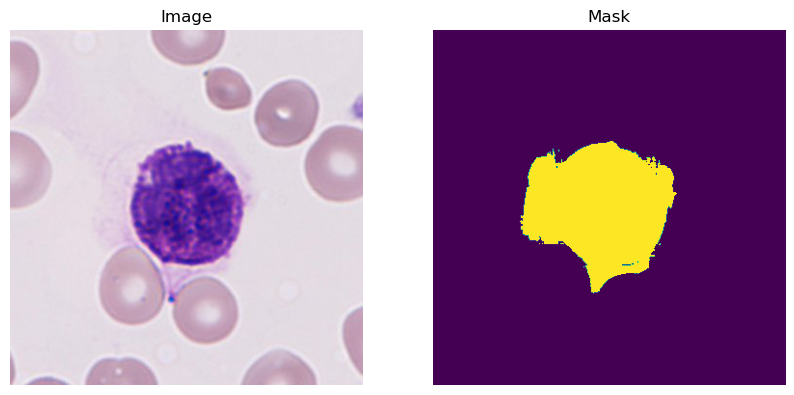

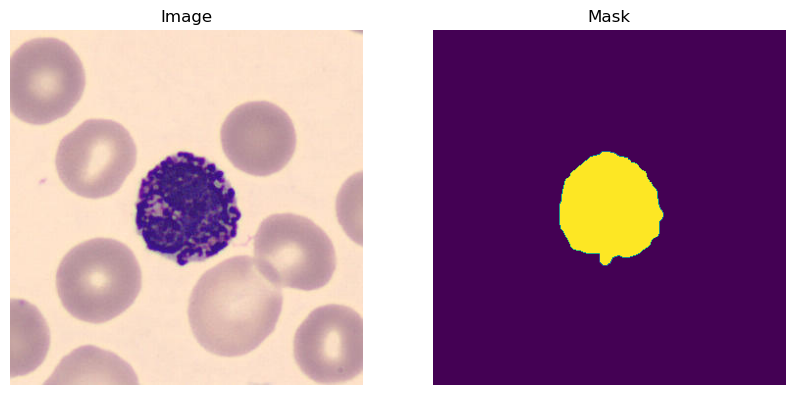

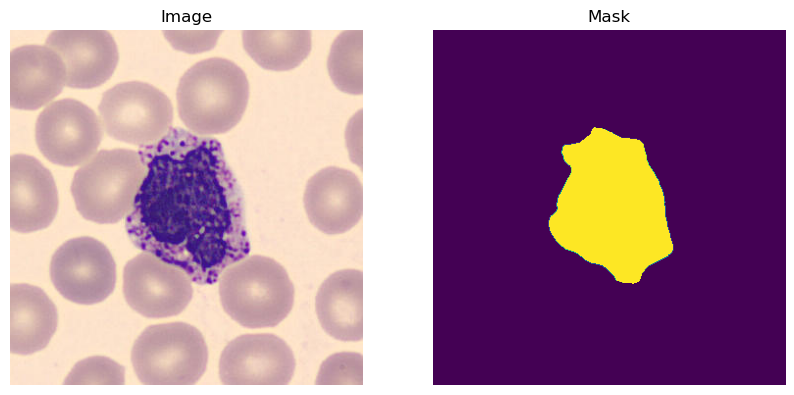

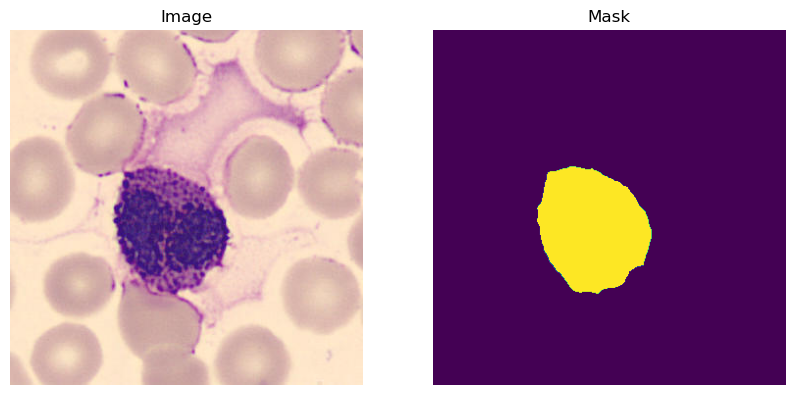

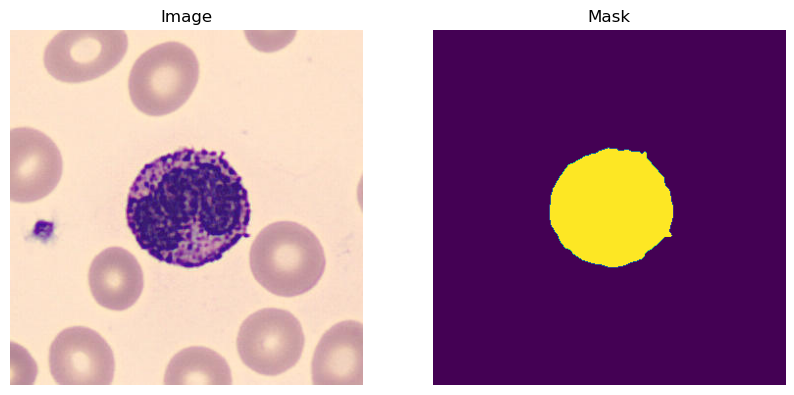

In [45]:
# Iterate over the first five image and mask paths and plot images
for i in range(5):
    image_path = merge_df.Path_x[i]
    mask_path = merge_df.Path_y[i]
    
    image = img = Image.open(image_path)
    mask = img = Image.open(mask_path)
    
    # Plot image and mask
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')
    
    axes[1].imshow(mask)
    axes[1].set_title('Mask')
    axes[1].axis('off')
    
    plt.show()